<a href="https://colab.research.google.com/github/akisnoobotrolis/ATM-LIKE-PROJECT/blob/main/hate_speech_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/kouskouss/hate_speech_detection_greek/blob/main/7_Hate_speech_detection_with_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greek Hate Speech Detection with Deep Learning

This notebook implements hate speech detection for Greek text using BERT models.

In [9]:
!pip -q install transformers==4.45.2 torch pandas numpy scikit-learn
!pip install transformers==4.30.2 -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)


In [6]:
import os, re, math, random, json
import numpy as np, pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score, roc_auc_score,
    precision_recall_curve, auc, confusion_matrix, classification_report
)

from dataclasses import dataclass
from typing import List, Dict

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, get_linear_schedule_with_warmup, set_seed
)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
amp_dtype = torch.bfloat16 if use_bf16 else torch.float16
print("BF16 supported:", use_bf16)


Device: cuda
BF16 supported: True


## 1. Installation and Setup

In [9]:
CSV_PATH = "/content/hate_speech_training.csv"

df_full = pd.read_csv(CSV_PATH, on_bad_lines='skip')
# Rename columns to match expected names
df = df_full.rename(columns={'Tweet': 'text', 'class': 'label'})

assert 'text' in df.columns and 'label' in df.columns, "Αναμένεται στήλες 'text' και 'label'."
# Convert label column to numeric, coercing errors, then to int
df['label'] = pd.to_numeric(df['label'], errors='coerce').astype(pd.Int64Dtype()) # Use Int64Dtype to allow NaN before dropping
df = df.dropna(subset=['text', 'label']) # Drop rows where label conversion failed
df['label'] = df['label'].astype(int) # Convert to standard int after dropping NaNs
df = df.drop_duplicates(subset=['text']).reset_index(drop=True)


print("Δείγματα:", len(df))
print("Κατανομή κλάσεων:")
print(df['label'].value_counts(normalize=True).round(3))
df.head()

Δείγματα: 22334
Κατανομή κλάσεων:
label
0    0.774
1    0.226
Name: proportion, dtype: float64


,text,label
0,Ας κανουν οτι θελουν δε με αφορα αλλα η ακριβε...,0
1,Η απορία της ημέρας!!\nΓιατί σε φωτογραφία που...,0
2,Ρε κόψτε την σύνδεση με τον βλακα Καραγιάννη έ...,1
3,Πολύ βολικό πάντως που λίγο πριν το τροχαίο μι...,0
4,Μόνο από τον ΠΑΟΚ σας πήραν μήπως σας πήραν β...,0


In [10]:
URL_RE = r"(https?://\S+|www\.\S+)"
USER_RE = r"@\w+"

def preprocess(s: str) -> str:
    s = str(s)
    s = re.sub(URL_RE, " [URL] ", s)
    s = re.sub(USER_RE, " [USER] ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df['text'] = df['text'].map(preprocess)
df.head()


,text,label
0,Ας κανουν οτι θελουν δε με αφορα αλλα η ακριβε...,0
1,Η απορία της ημέρας!! Γιατί σε φωτογραφία που ...,0
2,Ρε κόψτε την σύνδεση με τον βλακα Καραγιάννη έ...,1
3,Πολύ βολικό πάντως που λίγο πριν το τροχαίο μι...,0
4,Μόνο από τον ΠΑΟΚ σας πήραν μήπως σας πήραν βα...,0


In [11]:
MODEL_NAME = "nlpaueb/bert-base-greek-uncased-v1"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
special_tokens = ["[URL]", "[USER]", "[EMOJI]"]
to_add = [t for t in special_tokens if t not in tokenizer.get_vocab()]
if to_add:
    tokenizer.add_tokens(to_add)

collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)

def estimate_truncation(texts, sample_size=5000):
    sample = texts.sample(min(sample_size, len(texts)), random_state=SEED)
    lens = [len(tokenizer(t, add_special_tokens=True)['input_ids']) for t in sample]
    return {
        "pct_ge_90": float(np.mean(np.array(lens) >= 90)),
        "pct_ge_100": float(np.mean(np.array(lens) >= 100)),
        "pct_ge_125": float(np.mean(np.array(lens) >= 125)),
    }

print("Truncation estimate:", estimate_truncation(df['text']))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Truncation estimate: {'pct_ge_90': 0.0012, 'pct_ge_100': 0.0002, 'pct_ge_125': 0.0002}


In [12]:
from dataclasses import dataclass

@dataclass
class TextItem:
    text: str
    label: int

class TextDataset(Dataset):
    def __init__(self, items: List[TextItem], tokenizer, max_length: int = 128):
        self.items = items
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.items)
    def __getitem__(self, idx):
        it = self.items[idx]
        enc = self.tokenizer(it.text, add_special_tokens=True, truncation=True, max_length=self.max_length)
        enc["labels"] = int(it.label)
        return enc

train_df, val_df = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df['label'])

MAX_LENGTH = 128
train_items = [TextItem(t, int(y)) for t, y in zip(train_df['text'], train_df['label'])]
val_items   = [TextItem(t, int(y)) for t, y in zip(val_df['text'],   val_df['label'])]

train_ds = TextDataset(train_items, tokenizer, MAX_LENGTH)
val_ds   = TextDataset(val_items,   tokenizer, MAX_LENGTH)

BATCH_SIZE = 16
NUM_WORKERS = 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, collate_fn=collator)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, collate_fn=collator)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1]),
    y=train_df['label'].values
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
class_weights


tensor([0.6461, 2.2114], device='cuda:0')

## 2. Text Preprocessing Functions

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
if len(to_add) > 0:
    model.resize_token_embeddings(len(tokenizer))
model.to(device)

LR = 2e-5
EPOCHS = 5
ACC_STEPS = 4
MAX_NORMS = 1.0
WARMUP_RATIO = 0.1

try:
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=0.01, fused=True)
except TypeError:
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=0.01)

num_update_steps_per_epoch = math.ceil(len(train_loader) / ACC_STEPS)
max_train_steps = EPOCHS * num_update_steps_per_epoch
num_warmup_steps = int(WARMUP_RATIO * max_train_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=max_train_steps
)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


model.safetensors:   0%|          | 0.00/454M [00:00<?, ?B/s]

In [14]:
@torch.no_grad()
def evaluate(model, loader, device, threshold: float = 0.5) -> Dict[str, float]:
    model.eval()
    all_probs, all_labels = [], []
    with torch.inference_mode(), torch.amp.autocast("cuda", dtype=amp_dtype, enabled=(device.type=="cuda")):
        for batch in loader:
            labels = batch["labels"].to(device, non_blocking=True)
            inputs = {k: v.to(device, non_blocking=True) for k, v in batch.items() if k != "labels"}
            logits = model(**inputs).logits
            probs = torch.softmax(logits, dim=1)[:, 1].to(torch.float32)
            all_probs.append(probs.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())
    all_probs = np.concatenate(all_probs); all_labels = np.concatenate(all_labels)
    preds = (all_probs >= threshold).astype(int)
    return {
        "f1": f1_score(all_labels, preds, zero_division=0),
        "precision": precision_score(all_labels, preds, zero_division=0),
        "recall": recall_score(all_labels, preds, zero_division=0),
        "accuracy": accuracy_score(all_labels, preds),
        "auroc": roc_auc_score(all_labels, all_probs)
    }

def find_best_threshold(model, loader, device, grid=None) -> float:
    if grid is None:
        grid = np.linspace(0.2, 0.9, 36)
    best_th, best_f1 = 0.5, -1.0
    for th in grid:
        m = evaluate(model, loader, device, threshold=float(th))
        if m['f1'] > best_f1:
            best_f1, best_th = m['f1'], float(th)
    return best_th

def collect_logits_labels(loader):
    logits_all, labels_all = [], []
    model.eval()
    with torch.inference_mode(), torch.amp.autocast("cuda", dtype=amp_dtype, enabled=(device.type=="cuda")):
        for b in loader:
            yb = b["labels"].to(device, non_blocking=True)
            xb = {k: v.to(device, non_blocking=True) for k,v in b.items() if k!="labels"}
            lg = model(**xb).logits.detach().to(torch.float32)
            logits_all.append(lg.cpu().numpy())
            labels_all.append(yb.detach().cpu().numpy())
    return np.concatenate(logits_all), np.concatenate(labels_all)

def collect_probs_labels(loader):
    probs, labels = [], []
    with torch.inference_mode(), torch.amp.autocast("cuda", dtype=amp_dtype, enabled=(device.type=="cuda")):
        for b in loader:
            yb = b["labels"].cpu().numpy()
            xb = {k: v.to(device, non_blocking=True) for k,v in b.items() if k!="labels"}
            lg = model(**xb).logits
            pb = torch.softmax(lg, dim=1)[:,1].to(torch.float32).cpu().numpy()
            probs.append(pb); labels.append(yb)
    return np.concatenate(probs), np.concatenate(labels)


In [15]:
PATIENCE = 3
best_f1 = -1.0
best_state = None
epochs_no_improve = 0
global_step = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad(set_to_none=True)

    for step, batch in enumerate(train_loader, start=1):
        labels = batch.pop("labels").to(device, non_blocking=True)
        inputs = {k: v.to(device, non_blocking=True) for k, v in batch.items()}

        with torch.amp.autocast("cuda", dtype=amp_dtype, enabled=(device.type=="cuda")):
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels) / ACC_STEPS

        loss.backward()

        if step % ACC_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_NORMS)
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            global_step += 1

        running_loss += loss.item()

    val_05 = evaluate(model, val_loader, device, threshold=0.5)
    best_th = find_best_threshold(model, val_loader, device)
    val_best = evaluate(model, val_loader, device, threshold=best_th)

    print(
        f"Epoch {epoch}: train_loss={running_loss/len(train_loader):.4f} | "
        f"val@0.5 F1={val_05['f1']:.4f} P={val_05['precision']:.4f} R={val_05['recall']:.4f} "
        f"| val@{best_th:.2f} F1={val_best['f1']:.4f} P={val_best['precision']:.4f} R={val_best['recall']:.4f}"
    )

    if val_best['f1'] > best_f1:
        best_f1 = val_best['f1']
        best_state = {"model": model.state_dict(), "epoch": epoch, "val_f1": best_f1, "best_th": best_th}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict(best_state["model"])
    print(f"Loaded best model from epoch {best_state['epoch']} with val_f1={best_state['val_f1']:.4f} "
          f"@ threshold={best_state['best_th']:.2f}")
BEST_TH = float(best_state["best_th"])


Epoch 1: train_loss=0.1341 | val@0.5 F1=0.6917 P=0.6233 R=0.7770 | val@0.56 F1=0.6935 P=0.6455 R=0.7493
Epoch 2: train_loss=0.0957 | val@0.5 F1=0.6631 P=0.5246 R=0.9011 | val@0.82 F1=0.7025 P=0.6367 R=0.7836
Epoch 3: train_loss=0.0743 | val@0.5 F1=0.7008 P=0.6108 R=0.8219 | val@0.66 F1=0.7131 P=0.6588 R=0.7770
Epoch 4: train_loss=0.0573 | val@0.5 F1=0.7064 P=0.6439 R=0.7823 | val@0.58 F1=0.7088 P=0.6573 R=0.7691
Epoch 5: train_loss=0.0460 | val@0.5 F1=0.7082 P=0.6533 R=0.7731 | val@0.56 F1=0.7124 P=0.6644 R=0.7678
Loaded best model from epoch 3 with val_f1=0.7131 @ threshold=0.66


In [16]:
# Calibration (temperature scaling) και νέο threshold
val_logits, val_y = collect_logits_labels(val_loader)

def softmax_temp_np(logits, T):
    x = torch.from_numpy(logits) / T
    return torch.softmax(x, dim=1).numpy()

Ts = np.linspace(0.5, 2.0, 16)
best_T, best_th_cal, best_f1_cal = 1.0, BEST_TH, -1.0
grid = np.linspace(0.2, 0.9, 36)

for T in Ts:
    probs = softmax_temp_np(val_logits, T)[:, 1]
    for th in grid:
        f1 = f1_score(val_y, (probs >= th).astype(int), zero_division=0)
        if f1 > best_f1_cal:
            best_f1_cal, best_T, best_th_cal = float(f1), float(T), float(th)

CAL_T = float(best_T)
BEST_TH = float(best_th_cal)
print({"CAL_T": CAL_T, "BEST_TH": BEST_TH, "val_f1_cal": best_f1_cal})


{'CAL_T': 0.7, 'BEST_TH': 0.5800000000000001, 'val_f1_cal': 0.7127139364303179}


In [17]:
# Holdout 10% και αξιολόγηση με calibration
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=SEED)
idx = np.arange(len(df))
_, test_idx = next(sss.split(idx, df['label'].values))
df_holdout = df.iloc[test_idx].copy()
df_holdout['text'] = df_holdout['text'].map(preprocess)

hold_items = [TextItem(t, int(y)) for t, y in zip(df_holdout['text'], df_holdout['label'])]
hold_loader = DataLoader(TextDataset(hold_items, tokenizer, 128), batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, collate_fn=collator)

hold_logits, hold_y = collect_logits_labels(hold_loader)
hold_probs = softmax_temp_np(hold_logits, CAL_T)[:, 1]
hold_pred  = (hold_probs >= BEST_TH).astype(int)

print({
    "f1": f1_score(hold_y, hold_pred, zero_division=0),
    "precision": precision_score(hold_y, hold_pred, zero_division=0),
    "recall": recall_score(hold_y, hold_pred, zero_division=0),
    "accuracy": accuracy_score(hold_y, hold_pred),
    "auroc": roc_auc_score(hold_y, hold_probs)
})
print("Confusion:\n", confusion_matrix(hold_y, hold_pred))

prec, rec, thr = precision_recall_curve(hold_y, hold_probs)
print("PR-AUC:", auc(rec, prec))
print(classification_report(hold_y, hold_pred, digits=3))


{'f1': 0.7286108555657773, 'precision': 0.6804123711340206, 'recall': 0.7841584158415842, 'accuracy': 0.8679498657117278, 'auroc': np.float64(0.9153685813925522)}
Confusion:
 [[1543  186]
 [ 109  396]]
PR-AUC: 0.7666214583734299
              precision    recall  f1-score   support

           0      0.934     0.892     0.913      1729
           1      0.680     0.784     0.729       505

    accuracy                          0.868      2234
   macro avg      0.807     0.838     0.821      2234
weighted avg      0.877     0.868     0.871      2234



In [18]:
# Precision-first tuning και triage tuning
def tune_for_precision(probs, y, target_p=0.85):
    grid = np.linspace(0.5, 0.99, 100)
    out = []
    for th in grid:
        pred = (probs >= th).astype(int)
        pre = precision_score(y, pred, zero_division=0)
        rec = recall_score(y, pred, zero_division=0)
        f1  = f1_score(y, pred, zero_division=0)
        if pre >= target_p:
            out.append((f1, th, pre, rec))
    return max(out)[1:] if out else None

best = tune_for_precision(hold_probs, hold_y, target_p=0.85)
print("Precision-target result (th, P, R):", best)

def tune_triage(probs, y, review_target=0.08, tol=0.02):
    lo_grid = np.linspace(0.05, 0.40, 8)
    hi_grid = np.linspace(0.70, 0.95, 11)
    best = None
    for lo in lo_grid:
        for hi in hi_grid:
            tri = np.full_like(probs, -1, dtype=int)
            tri[probs >= hi] = 1
            tri[probs <= lo] = 0
            rate = np.mean(tri == -1)
            if abs(rate - review_target) > tol:
                continue
            mask = tri != -1
            if mask.sum() == 0:
                continue
            f1  = f1_score(y[mask], tri[mask], zero_division=0)
            pre = precision_score(y[mask], tri[mask], zero_division=0)
            rec = recall_score(y[mask], tri[mask], zero_division=0)
            if best is None or f1 > best[0]:
                best = (f1, lo, hi, pre, rec, rate)
    return None if best is None else {
        "f1": float(best[0]), "TH_LO": float(best[1]), "TH_HI": float(best[2]),
        "precision": float(best[3]), "recall": float(best[4]), "review_rate": float(best[5])
    }

res_tri = tune_triage(hold_probs, hold_y, review_target=0.08)
print("Triage tuned:", res_tri)

if res_tri:
    TH_LO, TH_HI = res_tri["TH_LO"], res_tri["TH_HI"]
else:
    TH_LO = max(0.30, BEST_TH - 0.20)
    TH_HI = max(BEST_TH, 0.80)

print("TH_LO, TH_HI:", TH_LO, TH_HI)


Precision-target result (th, P, R): None
Triage tuned: {'f1': 0.7715269804822044, 'TH_LO': 0.15000000000000002, 'TH_HI': 0.95, 'precision': 0.7433628318584071, 'recall': 0.801909307875895, 'review_rate': 0.09892569382273948}
TH_LO, TH_HI: 0.15000000000000002 0.95


In [13]:
# --- Holdout FP/FN extraction and TH_HI simulation
import pandas as pd, numpy as np
# df_holdout, hold_probs, hold_y are expected from previous cells
hold_df = pd.DataFrame({
    'text': df_holdout['text'].values,
    'label': hold_y,
    'prob': hold_probs
})
# Predictions at BEST_TH
hold_df['pred_best'] = (hold_df['prob'] >= float(BEST_TH)).astype(int)
# Top false positives: true label 0, predicted positive at BEST_TH
fps = hold_df[(hold_df['label'] == 0) & (hold_df['pred_best'] == 1)].copy()
fps = fps.sort_values('prob', ascending=False)
# Top false negatives: true label 1, predicted negative at BEST_TH (borderline positives)
fns = hold_df[(hold_df['label'] == 1) & (hold_df['pred_best'] == 0)].copy()
fns = fns.sort_values('prob', ascending=False)
print('FPs found:', len(fps), 'FNs found:', len(fns))
# Save samples for manual inspection
os.makedirs('analysis_artifacts', exist_ok=True)
fps.head(200).to_csv('analysis_artifacts/holdout_top_FPs.csv', index=False, encoding='utf-8')
fns.head(200).to_csv('analysis_artifacts/holdout_top_FNs.csv', index=False, encoding='utf-8')
print('Saved top FPs/FNs to analysis_artifacts/ (top 200)')
# Simulate stricter auto-accept thresholds and report auto-precision and coverage
sim_ths = [float(TH_HI), 0.95, 0.98]  # include current TH_HI plus 0.95 and 0.98
results = []
for th in sim_ths:
    mask_auto = hold_df['prob'] >= th
    n_auto = int(mask_auto.sum())
    if n_auto == 0:
        prec = float('nan')
    else:
        tp = int(((hold_df['label'] == 1) & mask_auto).sum())
        fp = int(((hold_df['label'] == 0) & mask_auto).sum())
        prec = tp / (tp + fp) if (tp + fp) > 0 else float('nan')
    coverage = n_auto / len(hold_df)
    # review rate under triage using TH_LO (fraction sent to review between TH_LO and th)
    review_mask = (hold_df['prob'] > float(TH_LO)) & (hold_df['prob'] < th)
    review_rate = float(review_mask.mean())
    results.append({'threshold': th, 'n_auto': n_auto, 'coverage': coverage, 'auto_precision': prec, 'review_rate': review_rate})
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
# Also compute precision/recall curve points near high thresholds for finer view
grid_high = np.linspace(0.8, 0.999, 200)
best_for_precision = []
for th in grid_high:
    mask = hold_df['prob'] >= th
    if mask.sum() == 0:
        continue
    tp = int(((hold_df['label'] == 1) & mask).sum())
    fp = int(((hold_df['label'] == 0) & mask).sum())
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    cov = mask.sum() / len(hold_df)
    best_for_precision.append((th, prec, cov, tp, fp))
best_for_precision_df = pd.DataFrame(best_for_precision, columns=['threshold','precision','coverage','tp','fp'])
# Save the dataframe for plotting or inspection
best_for_precision_df.to_csv('analysis_artifacts/holdout_precision_vs_threshold.csv', index=False, encoding='utf-8')
print('Saved precision vs threshold data to analysis_artifacts/holdout_precision_vs_threshold.csv')

FPs found: 196 FNs found: 119
Saved top FPs/FNs to analysis_artifacts/ (top 200)
 threshold  n_auto  coverage  auto_precision  review_rate
     0.925     521  0.233214        0.689060     0.099373
     0.950     502  0.224709        0.699203     0.107878
     0.980     456  0.204118        0.725877     0.128469
Saved precision vs threshold data to analysis_artifacts/holdout_precision_vs_threshold.csv


In [25]:
import json, os
SAVE_DIR = "greek_hatespeech_ckpt_epoch3"
os.makedirs(SAVE_DIR, exist_ok=True)
model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

cfg = {
    "model_name": "nlpaueb/bert-base-greek-uncased-v1",
    "best_threshold": BEST_TH,
    "max_length": 128,
    "label_map": { "0": "non_hate", "1": "hate" }
}
with open(os.path.join(SAVE_DIR, "config.json"), "w", encoding="utf-8") as f:
    json.dump(cfg, f, ensure_ascii=False, indent=2)
print("Saved to:", SAVE_DIR)


Saved to: greek_hatespeech_ckpt_epoch3


In [26]:
# Περίπτωση Β: φτιάξε holdout από το df
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=SEED)
idx = np.arange(len(df))
train_idx, test_idx = next(sss.split(idx, df['label'].values))
df_holdout = df.iloc[test_idx].copy()
df_holdout['text'] = df_holdout['text'].map(preprocess)

hold_items = [TextItem(t, int(y)) for t, y in zip(df_holdout['text'], df_holdout['label'])]
hold_loader = DataLoader(TextDataset(hold_items, tokenizer, 128), batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, collate_fn=collator)

hold_metrics = evaluate(model, hold_loader, device, threshold=BEST_TH)
print("HOLDOUT @BEST_TH:", hold_metrics)


HOLDOUT @BEST_TH: {'f1': 0.704612365063788, 'precision': 0.6903846153846154, 'recall': 0.7194388777555111, 'accuracy': 0.8652641002685766, 'auroc': np.float64(0.9067269986659199)}


In [27]:
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix

def collect_probs_labels(loader):
    probs, labels = [], []
    with torch.inference_mode(), torch.amp.autocast("cuda", dtype=amp_dtype, enabled=(device.type=="cuda")):
        for b in loader:
            yb = b["labels"].cpu().numpy()
            xb = {k: v.to(device) for k,v in b.items() if k!="labels"}
            pb = torch.softmax(model(**xb).logits, dim=1)[:,1].cpu().numpy()
            probs.append(pb); labels.append(yb)
    return np.concatenate(probs), np.concatenate(labels)

probs, y = collect_probs_labels(test_loader if 'test_loader' in globals() else hold_loader)
prec, rec, thr = precision_recall_curve(y, probs)
print("PR-AUC:", auc(rec, prec))

pred = (probs >= BEST_TH).astype(int)
print("Confusion:\n", confusion_matrix(y, pred))

# Δείγματα σφάλματος
err_idx = np.where(pred != y)[0]
print("Errors:", len(err_idx))
sample_err = err_idx[:20]
[(int(y[i]), float(probs[i]), df_test.iloc[i]['text'] if 'df_test' in globals() else df_holdout.iloc[i]['text']) for i in sample_err]


PR-AUC: 0.769358338412145
Confusion:
 [[1574  161]
 [ 140  359]]
Errors: 301


[(1,
  0.7082125544548035,
  "Ρε μπασταρδοι τωρα σας βριζουν και οι δικοι σας απ'το καναλι σας😂 #ΝΔ_ΤΕΛΟΣ #νδ_δολοφονοι #νδ_εγκληματιες #ΝΔ_ΣΥΜΜΟΡΙΑ"),
 (1,
  0.07978201657533646,
  'Οχι δεν ειναι μεμπτο να δουλευεις στον Χατζηνικολαου. Μια χαρα ειναι🤡. Εσυ γαμιεσαι ομως. Οπως και να χει'),
 (1,
  0.7386690378189087,
  'Η Μανουλα δεν βασταει γερα Μεχρι και οι ταλιμπαν γιδογαμιαδες την εχουν κανει χυσοδοχειο Αλλα δες το θετικο Θα πας για μπυρα με 20αρικο απο τα χερια των τζιχαντιων,και κατουρημενο αλβανο στην πλατεια'),
 (1,
  0.5145222544670105,
  'Μόνο αριστεροί ψεκασμένοι Έλληνες πιστεύουν αυτά που λεεί η κυριά Δεναξά που αγαπάει τον Βλαδίμηρο τον Πούτιν. Επανάσταση στη Γαλλία δεν θα γίνει και δεν γίνεται. Ο κύριος Πικραμένος έχει δίκαιο και όσοι μένουμε Γαλλία το ξέρουμε. Πηγαίνετε σε αριστερά site πχ Liberation να δείτε'),
 (0,
  0.9399133324623108,
  '#πολακη_ξεφτιλα #πολακης #συριζα_σουργελα #συριζαλητες #συριζα_δολοφονοι #συριζα_ξεφτιλες #τουρκοζαιοι #μμε_ξεφτιλες #σκαι_ξεφτιλες

In [29]:
@torch.no_grad()
def predict_proba(texts: List[str], max_length: int = 128) -> np.ndarray:
    model.eval()
    proc = [preprocess(t) for t in texts]
    # Added padding=True to handle batch processing
    enc = tokenizer(proc, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    enc = {k: v.to(device) for k,v in enc.items()}
    with torch.amp.autocast("cuda", dtype=amp_dtype, enabled=(device.type=="cuda")):
        logits = model(**enc).logits
        return torch.softmax(logits, dim=1)[:,1].cpu().numpy()

def predict(texts: List[str], threshold: float = None) -> List[int]:
    th = BEST_TH if threshold is None else float(threshold)
    p = predict_proba(texts)
    return (p >= th).astype(int).tolist()

# Παράδειγμα
print(predict(["Σε σέβομαι.", "Αυτό είναι αηδιαστικό και απαράδεκτο."]))

[1, 1]


In [36]:
texts = ["Σε γαμαω ρε πουστη.", "τον παιρνεις;"]
print("BEST_TH:", BEST_TH)
print("probs:", predict_proba(texts))
print("preds:", predict(texts))


BEST_TH: 0.78
probs: [0.9950177  0.99298817]
preds: [1, 1]


In [38]:
@torch.no_grad()
def evaluate(model, loader, device, threshold: float = 0.5) -> Dict[str, float]:
    model.eval()
    all_probs, all_labels = [], []
    with torch.inference_mode(), torch.amp.autocast("cuda", dtype=amp_dtype, enabled=(device.type=="cuda")):
        for batch in loader:
            labels = batch["labels"].to(device, non_blocking=True)
            inputs = {k: v.to(device, non_blocking=True) for k, v in batch.items() if k != "labels"}
            logits = model(**inputs).logits
            probs = torch.softmax(logits, dim=1)[:, 1].to(torch.float32)
            all_probs.append(probs.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())
    all_probs = np.concatenate(all_probs); all_labels = np.concatenate(all_labels)
    preds = (all_probs >= threshold).astype(int)
    return {
        "f1": f1_score(all_labels, preds, zero_division=0),
        "precision": precision_score(all_labels, preds, zero_division=0),
        "recall": recall_score(all_labels, preds, zero_division=0),
        "accuracy": accuracy_score(all_labels, preds),
        "auroc": roc_auc_score(all_labels, all_probs)
    }


In [39]:
def collect_logits_labels(loader):
    logits_all, labels_all = [], []
    model.eval()
    with torch.inference_mode(), torch.amp.autocast("cuda", dtype=amp_dtype, enabled=(device.type=="cuda")):
        for b in loader:
            yb = b["labels"].to(device, non_blocking=True)
            xb = {k: v.to(device, non_blocking=True) for k,v in b.items() if k!="labels"}
            lg = model(**xb).logits.detach().to(torch.float32)
            logits_all.append(lg.cpu().numpy())
            labels_all.append(yb.detach().cpu().numpy())
    return np.concatenate(logits_all), np.concatenate(labels_all)


In [40]:
def collect_probs_labels(loader):
    probs, labels = [], []
    with torch.inference_mode(), torch.amp.autocast("cuda", dtype=amp_dtype, enabled=(device.type=="cuda")):
        for b in loader:
            yb = b["labels"].cpu().numpy()
            xb = {k: v.to(device, non_blocking=True) for k,v in b.items() if k!="labels"}
            lg = model(**xb).logits
            pb = torch.softmax(lg, dim=1)[:,1].to(torch.float32).cpu().numpy()
            probs.append(pb); labels.append(yb)
    return np.concatenate(probs), np.concatenate(labels)


In [41]:
val_logits, val_y = collect_logits_labels(val_loader)

def softmax_temp_np(logits, T):
    x = torch.from_numpy(logits) / T
    return torch.softmax(x, dim=1).numpy()

Ts = np.linspace(0.5, 2.0, 16)
best_T, best_th_cal, best_f1_cal = 1.0, 0.78, -1.0
grid = np.linspace(0.2, 0.9, 36)

for T in Ts:
    probs = softmax_temp_np(val_logits, T)[:, 1]
    for th in grid:
        f1 = f1_score(val_y, (probs >= th).astype(int), zero_division=0)
        if f1 > best_f1_cal:
            best_f1_cal, best_T, best_th_cal = float(f1), float(T), float(th)

CAL_T = best_T
BEST_TH = best_th_cal
print({"CAL_T": CAL_T, "BEST_TH": BEST_TH, "val_f1_cal": best_f1_cal})


{'CAL_T': 0.5, 'BEST_TH': 0.78, 'val_f1_cal': 0.7039106145251397}


In [42]:
@torch.no_grad()
def predict_proba(texts: List[str], max_length: int = 128) -> np.ndarray:
    model.eval()
    proc = [preprocess(t) for t in texts]
    enc = tokenizer(proc, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    enc = {k: v.to(device, non_blocking=True) for k,v in enc.items()}
    with torch.amp.autocast("cuda", dtype=amp_dtype, enabled=(device.type=="cuda")):
        logits = model(**enc).logits / CAL_T
        probs = torch.softmax(logits, dim=1)[:, 1].to(torch.float32)
        return probs.cpu().numpy()


In [43]:
# Αξιολόγηση holdout με calibration
hold_logits, hold_y = collect_logits_labels(hold_loader)

def softmax_temp_np(logits, T):
    x = torch.from_numpy(logits) / T
    return torch.softmax(x, dim=1).numpy()

hold_probs = softmax_temp_np(hold_logits, CAL_T)[:, 1]
hold_pred  = (hold_probs >= BEST_TH).astype(int)

from sklearn.metrics import precision_recall_curve, auc, confusion_matrix

print({
    "f1": f1_score(hold_y, hold_pred, zero_division=0),
    "precision": precision_score(hold_y, hold_pred, zero_division=0),
    "recall": recall_score(hold_y, hold_pred, zero_division=0),
    "accuracy": accuracy_score(hold_y, hold_pred),
    "auroc": roc_auc_score(hold_y, hold_probs)
})
print("Confusion:\n", confusion_matrix(hold_y, hold_pred))

prec, rec, thr = precision_recall_curve(hold_y, hold_probs)
print("PR-AUC:", auc(rec, prec))


{'f1': 0.7069767441860465, 'precision': 0.6597222222222222, 'recall': 0.7615230460921844, 'accuracy': 0.8589973142345568, 'auroc': np.float64(0.9067269986659199)}
Confusion:
 [[1539  196]
 [ 119  380]]
PR-AUC: 0.769358338412145


In [44]:
# Αποθήκευση artifacts (μοντέλο, tokenizer, config)
import os, json
SAVE_DIR = "greek_hatespeech_ckpt_epoch3"
os.makedirs(SAVE_DIR, exist_ok=True)
model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

TH_LO = max(0.30, float(BEST_TH) - 0.20)
TH_HI = max(float(BEST_TH), 0.80)

cfg = {
    "model_name": "nlpaueb/bert-base-greek-uncased-v1",
    "best_threshold": float(BEST_TH),
    "calibration_T": float(CAL_T),
    "triage": {"TH_LO": float(TH_LO), "TH_HI": float(TH_HI)},
    "max_length": 128,
    "label_map": {"0": "non_hate", "1": "hate"}
}
with open(os.path.join(SAVE_DIR, "config.json"), "w", encoding="utf-8") as f:
    json.dump(cfg, f, ensure_ascii=False, indent=2)
print("Saved:", SAVE_DIR)


Saved: greek_hatespeech_ckpt_epoch3


In [45]:
# Inference helpers με calibration και triage
@torch.no_grad()
def predict_proba(texts: List[str], max_length: int = 128) -> np.ndarray:
    model.eval()
    proc = [preprocess(t) for t in texts]
    enc = tokenizer(proc, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    enc = {k: v.to(device, non_blocking=True) for k,v in enc.items()}
    with torch.amp.autocast("cuda", dtype=amp_dtype, enabled=(device.type=="cuda")):
        logits = model(**enc).logits / CAL_T
        probs = torch.softmax(logits, dim=1)[:, 1].to(torch.float32)
        return probs.cpu().numpy()

def predict(texts: List[str], threshold: float = None) -> List[int]:
    th = float(BEST_TH) if threshold is None else float(threshold)
    return (predict_proba(texts) >= th).astype(int).tolist()

def predict_triage(texts: List[str]) -> List[int]:
    p = predict_proba(texts)
    out = []
    for pi in p:
        if   pi >= TH_HI: out.append(1)
        elif pi <= TH_LO: out.append(0)
        else:             out.append(-1)
    return out

ex = ["Σε σέβομαι.", "Αυτό είναι αηδιαστικό και απαράδεκτο."]
print("BEST_TH:", BEST_TH, "CAL_T:", CAL_T, "TH_LO/HIGH:", TH_LO, TH_HI)
print("probs:", predict_proba(ex))
print("preds:", predict(ex))
print("triage:", predict_triage(ex))


BEST_TH: 0.78 CAL_T: 0.5 TH_LO/HIGH: 0.5800000000000001 0.8
probs: [0.98959166 0.9603612 ]
preds: [1, 1]
triage: [1, 1]


In [46]:
# Μαζική αξιολόγηση σε holdout με calibration και triage
probs_h, y_h = softmax_temp_np(hold_logits, CAL_T)[:,1], hold_y
pred_h  = (probs_h >= BEST_TH).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_h, pred_h, digits=3))

tri = np.array([1 if p>=TH_HI else (0 if p<=TH_LO else -1) for p in probs_h])
review_rate = np.mean(tri == -1)
print("Triage review rate:", round(float(review_rate), 3))

# Σφάλματα για manual review
err_idx = np.where(pred_h != y_h)[0][:50]
errors = [(int(y_h[i]), float(probs_h[i])) for i in err_idx]
print("Errors sample:", errors[:10])


              precision    recall  f1-score   support

           0      0.928     0.887     0.907      1735
           1      0.660     0.762     0.707       499

    accuracy                          0.859      2234
   macro avg      0.794     0.824     0.807      2234
weighted avg      0.868     0.859     0.862      2234

Triage review rate: 0.03
Errors sample: [(0, 0.8204694986343384), (1, 0.007460643537342548), (0, 0.8289388418197632), (1, 0.5290200710296631), (0, 0.9959298968315125), (1, 0.12852513790130615), (0, 0.974628746509552), (0, 0.9971550703048706), (0, 0.9820137619972229), (1, 0.009268013760447502)]


In [47]:
# Αποθήκευση calibration/threshold στο ίδιο artifact για κατανάλωση από υπηρεσία
with open(os.path.join(SAVE_DIR, "calibration.json"), "w", encoding="utf-8") as f:
    json.dump({"CAL_T": float(CAL_T), "BEST_TH": float(BEST_TH), "TH_LO": float(TH_LO), "TH_HI": float(TH_HI)},
              f, ensure_ascii=False, indent=2)
print("Calibration saved.")


Calibration saved.


In [48]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def tune_threshold(probs, y, target_precision=None, target_recall=None):
    grid = np.linspace(0.5, 0.95, 91)
    best = (-1.0, 0.5, 0.0, 0.0)  # f1, th, precision, recall
    for th in grid:
        pred = (probs >= th).astype(int)
        pre = precision_score(y, pred, zero_division=0)
        rec = recall_score(y, pred, zero_division=0)
        if target_precision is not None and pre < target_precision:
            continue
        if target_recall is not None and rec < target_recall:
            continue
        f1 = f1_score(y, pred, zero_division=0)
        if f1 > best[0]:
            best = (f1, th, pre, rec)
    return {"f1": best[0], "th": best[1], "precision": best[2], "recall": best[3]}

res_bin = tune_threshold(hold_probs, hold_y, target_precision=0.72)  # ή target_recall=0.72
print("Binary tuned:", res_bin)
BEST_TH = float(res_bin["th"])


Binary tuned: {'f1': -1.0, 'th': 0.5, 'precision': 0.0, 'recall': 0.0}


In [49]:
from sklearn.metrics import f1_score, precision_score, recall_score

def tune_triage(probs, y, review_target=0.08, tol=0.02):
    lo_grid = np.linspace(0.05, 0.40, 8)
    hi_grid = np.linspace(0.70, 0.95, 11)
    best = None
    for lo in lo_grid:
        for hi in hi_grid:
            tri = np.full_like(probs, -1, dtype=int)
            tri[probs >= hi] = 1
            tri[probs <= lo] = 0
            rate = np.mean(tri == -1)
            if abs(rate - review_target) > tol:
                continue
            mask = tri != -1
            if mask.sum() == 0:
                continue
            f1  = f1_score(y[mask], tri[mask], zero_division=0)
            pre = precision_score(y[mask], tri[mask], zero_division=0)
            rec = recall_score(y[mask], tri[mask], zero_division=0)
            if best is None or f1 > best[0]:
                best = (f1, lo, hi, pre, rec, rate)
    return None if best is None else {
        "f1": float(best[0]), "TH_LO": float(best[1]), "TH_HI": float(best[2]),
        "precision": float(best[3]), "recall": float(best[4]), "review_rate": float(best[5])
    }

res_tri = tune_triage(hold_probs, hold_y, review_target=0.08)  # π.χ. 8% manual review
print("Triage tuned:", res_tri)

if res_tri:
    TH_LO, TH_HI = res_tri["TH_LO"], res_tri["TH_HI"]
else:
    # fallback στα σημερινά thresholds
    TH_LO = max(0.30, BEST_TH - 0.20)
    TH_HI = max(BEST_TH, 0.80)


Triage tuned: {'f1': 0.7534102833158447, 'TH_LO': 0.1, 'TH_HI': 0.9249999999999999, 'precision': 0.6890595009596929, 'recall': 0.8310185185185185, 'review_rate': 0.09937332139659803}


In [50]:
import json, os

SAVE_DIR = "greek_hatespeech_ckpt_epoch3"
cfg_path = os.path.join(SAVE_DIR, "config.json")

with open(cfg_path, "r", encoding="utf-8") as f:
    cfg = json.load(f)

cfg.update({
    "best_threshold": float(BEST_TH),
    "calibration_T": float(CAL_T),
    "triage": {"TH_LO": float(TH_LO), "TH_HI": float(TH_HI)},
    "max_length": 128
})

with open(cfg_path, "w", encoding="utf-8") as f:
    json.dump(cfg, f, ensure_ascii=False, indent=2)

print("Config updated:", cfg)


Config updated: {'model_name': 'nlpaueb/bert-base-greek-uncased-v1', 'best_threshold': 0.5, 'calibration_T': 0.5, 'triage': {'TH_LO': 0.1, 'TH_HI': 0.9249999999999999}, 'max_length': 128, 'label_map': {'0': 'non_hate', '1': 'hate'}}


In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def tune_for_precision(probs, y, target_p=0.85):
    grid = np.linspace(0.5, 0.99, 100)
    out = []
    for th in grid:
        pred = (probs >= th).astype(int)
        pre = precision_score(y, pred, zero_division=0)
        rec = recall_score(y, pred, zero_division=0)
        f1  = f1_score(y, pred, zero_division=0)
        if pre >= target_p:
            out.append((f1, th, pre, rec))
    return max(out)[1:] if out else None  # th, precision, recall

best = tune_for_precision(hold_probs, hold_y, target_p=0.85)
print("th, P, R =", best)
BEST_TH = float(best[0]) if best else BEST_TH


th, P, R = None


In [ ]:
# Δείκτες FP στο holdout
fp_idx = np.where((hold_y==0) & (hold_probs>=0.9))[0]
# πρόσθεσέ τα πίσω στο training set ως extra negatives με upsampling (π.χ. 2×)


In [ ]:
import shutil
source_folder = "/content/final_hate_speech_model"
destination_folder = "/content/drive/MyDrive/final_hate_speech_model"

# 3. Έλεγξε αν ο φάκελος υπάρχει ήδη στο Drive
if os.path.exists(destination_folder):
    print(f"⚠ Warning: Ο φάκελος '{destination_folder}' υπάρχει ήδη στο Drive σου.")
    # Προαιρετικά: Διέγραψέ τον παλιό αν θες να τον αντικαταστήσεις
    # print("Deleting old folder to replace it...")
    # shutil.rmtree(destination_folder)

# 4. Αντέγραψε ολόκληρο τον φάκελο από το Colab στο Drive
if os.path.exists(source_folder):
    try:
        shutil.copytree(source_folder, destination_folder)
        print(f"\n✓✓✓ SUCCESS! ✓✓✓")
        print(f"Ο φάκελος '{source_folder}' αντιγράφηκε επιτυχώς στο Google Drive σου!")
    except FileExistsError:
        print("\nΟ φάκελος υπάρχει ήδη. Η αντιγραφή παραλείφθηκε.")
    except Exception as e:
        print(f"\n❌ Error during copy: {e}")
else:
    print(f"❌ Error: Δεν βρέθηκε ο φάκελος '{source_folder}'.")
    print("Μήπως έχεις ήδη κλείσει το runtime;")


✓✓✓ SUCCESS! ✓✓✓
Ο φάκελος '/content/final_hate_speech_model' αντιγράφηκε επιτυχώς στο Google Drive σου!


## Summary

This notebook implements:
1. **Binary Classification**: Hate vs Non-Hate speech detection
2. **Multi-Class Classification**: Categorization of hate speech into 3 categories
3. **Proper K-Fold Cross-Validation**: 5-fold CV with proper metrics aggregation
4. **Visualization**: Word clouds and confusion matrices

Key improvements:
- ✅ No code duplication
- ✅ Proper cross-validation with all folds used
- ✅ Clear structure and documentation
- ✅ Comprehensive metrics reporting
- ✅ Memory-efficient (only one model in memory at a time)

LLama Training


In [ ]:
csv_file = 'issue_categories.csv'
df = pd.read_csv(csv_file)

print(f"Dataset loaded: {len(df)} rows")
print(f"Columns: {df.columns.tolist()}")

Dataset loaded: 2677 rows
Columns: ['text', 'label']


In [ ]:
# --- 3.1 Καθαρισμός Δεδομένων ---

# (α) Αφαίρεση κενών γραμμών (NaN values)
nan_rows = df_full.isnull().sum().sum()
if nan_rows > 0:
    print(f"Βρέθηκαν {nan_rows} κενές εγγραφές (NaN). Γίνεται αφαίρεση...")
    df_full = df_full.dropna()
    print(f"Μέγεθος μετά την αφαίρεση NaN: {len(df_full)}")

# (β) Αφαίρεση Διπλότυπων (Βάσει του κειμένου)
initial_rows = len(df_full)
df_full = df_full.drop_duplicates(subset=['text'])
duplicates_removed = initial_rows - len(df_full)
if duplicates_removed > 0:
    print(f"Αφαιρέθηκαν {duplicates_removed} διπλότυπες εγγραφές.")
    print(f"Μέγεθος μετά την αφαίρεση διπλότυπων: {len(df_full)}")

# (γ) Εφαρμογή Καθαρισμού Κειμένου (Αφαίρεση τόνων, URL, @mentions κλπ)
# Αυτό προϋποθέτει ότι το κελί '68814cb6' (με τη 'preprocess_for_bert') έχει εκτελεστεί
print("\nΕφαρμογή κανονικοποίησης (αφαίρεση τόνων, URL, κλπ)...")
# Εξασφαλίζουμε ότι η στήλη 'text' είναι string
df_full['processed_text'] = df_full['text'].astype(str).apply(preprocess_for_bert)
print("Η κανονικοποίηση ολοκληρώθηκε.")

# --- 3.2 Εμφάνιση Δείγματος ---
print("\n--- Δείγμα Επεξεργασμένων Δεδομένων ---")
for i in range(min(5, len(df_full))):
    print(f"Original:   {df_full['text'].iloc[i]}")
    print(f"Processed:  {df_full['processed_text'].iloc[i]}")
    print(f"Label:      {df_full['label'].iloc[i]}")
    print("-" * 20)

Βρέθηκαν 2 κενές εγγραφές (NaN). Γίνεται αφαίρεση...
Μέγεθος μετά την αφαίρεση NaN: 2675
Αφαιρέθηκαν 492 διπλότυπες εγγραφές.
Μέγεθος μετά την αφαίρεση διπλότυπων: 2183

Εφαρμογή κανονικοποίησης (αφαίρεση τόνων, URL, κλπ)...
Η κανονικοποίηση ολοκληρώθηκε.

--- Δείγμα Επεξεργασμένων Δεδομένων ---
Original:   Η άσφαλτος είναι τόσο φθαρμένη που φαίνεται το χώμα από κάτω.
Processed:  η ασφαλτος ειναι τοσο φθαρμενη που φαινεται το χωμα απο κατω
Label:      Οδοποιία
--------------------
Original:   Οι λακκούβες μετά τη βροχή είναι αόρατες και πολύ επικίνδυνες.
Processed:  οι λακκουβες μετα τη βροχη ειναι αορατες και πολυ επικινδυνες
Label:      Οδοποιία
--------------------
Original:   Ο δρόμος έχει ρωγμές παντού, σε λίγο θα διαλυθεί.
Processed:  ο δρομος εχει ρωγμες παντου σε λιγο θα διαλυθει
Label:      Οδοποιία
--------------------
Original:   Τα έργα στο δρόμο δεν έχουν καμία σήμανση ασφαλείας.
Processed:  τα εργα στο δρομο δεν εχουν καμια σημανση ασφαλειας
Label:      Οδοποιία
---------

In [ ]:
# --- 3.3 Κωδικοποίηση Ετικετών (Labels) ---
print("\n--- 3.3 Κωδικοποίηση Ετικετών ---")

# Παίρνουμε τις μοναδικές ετικέτες με τη σειρά
unique_labels = sorted(df_full['label'].unique())
NUM_LABELS = len(unique_labels)

# Δημιουργούμε λεξικά για τη μετατροπή
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for i, label in enumerate(unique_labels)}

# Εφαρμόζουμε τη μετατροπή σε μια νέα στήλη 'label_id'
df_full['label_id'] = df_full['label'].map(label_to_id)

print(f"Βρέθηκαν {NUM_LABELS} μοναδικές κατηγορίες.")
print("Mapping (label_to_id):")
print(json.dumps(label_to_id, indent=2, ensure_ascii=False))

# --- 3.4 Έλεγχος Κατανομής Κλάσεων ---
print("\n--- 3.4 Τελική Κατανομή Κλάσεων (μετά τον καθαρισμό) ---")
print(df_full['label'].value_counts())


--- 3.3 Κωδικοποίηση Ετικετών ---
Βρέθηκαν 10 μοναδικές κατηγορίες.
Mapping (label_to_id):
{
  "Αποχέτευση / Ύδρευση": 0,
  "Δημόσιοι χώροι": 1,
  "Ζώα / Αδέσποτα": 2,
  "Ηχορύπανση": 3,
  "Καθαριότητα": 4,
  "Κυκλοφορία": 5,
  "Οδοποιία": 6,
  "Πεζοδρόμια": 7,
  "Πρασίνου": 8,
  "Φωτισμός": 9
}

--- 3.4 Τελική Κατανομή Κλάσεων (μετά τον καθαρισμό) ---
label
Φωτισμός                306
Ζώα / Αδέσποτα          270
Κυκλοφορία              262
Δημόσιοι χώροι          219
Πρασίνου                214
Πεζοδρόμια              194
Καθαριότητα             194
Ηχορύπανση              191
Αποχέτευση / Ύδρευση    177
Οδοποιία                156
Name: count, dtype: int64


In [ ]:
# Ensure no NaN values in the 'label_id' column before splitting
df_cleaned = df.dropna(subset=['label_id']).copy()

print("\\nApplying optimized BERT preprocessing...")
df_cleaned['processed_text'] = df_cleaned['text'].astype(str).apply(preprocess_for_bert)
print("Preprocessing complete.")

# --- 4. Train-Validation Split (80/20) ---
X = df_cleaned['processed_text']
y = df_cleaned['label_id']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y  # Εξασφαλίζει ότι το split σέβεται την αναλογία των 10 κλάσεων
)

print(f"Data split: {len(X_train)} train, {len(X_val)} validation samples.")

\nApplying optimized BERT preprocessing...
Preprocessing complete.
Data split: 2140 train, 535 validation samples.


In [ ]:
# --- 5. Υπολογισμός Class Weights για 10 Κλάσεις ---
print("Calculating class weights for multi-class problem...")

# Define device here to ensure it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Υπολογίζουμε τα βάρη αυτόματα με βάση την ανισορροπία
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Μετατροπή σε Tensor για το PyTorch
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(f"Weights for classes 0-{NUM_LABELS-1}:")
print(class_weights_tensor)

Calculating class weights for multi-class problem...
Using device: cuda
Weights for classes 0-9:
tensor([0.9683, 0.9640, 0.9596, 0.9772, 0.9817, 0.9772, 1.7120, 0.9469, 0.9772,
        0.8629], device='cuda:0')


--- 4. Εύρεση Βέλτιστου Max Length ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Υπολογισμός μήκους token για όλες τις εγγραφές (αυτό μπορεί να πάρει λίγο χρόνο)...
Ο υπολογισμός ολοκληρώθηκε.


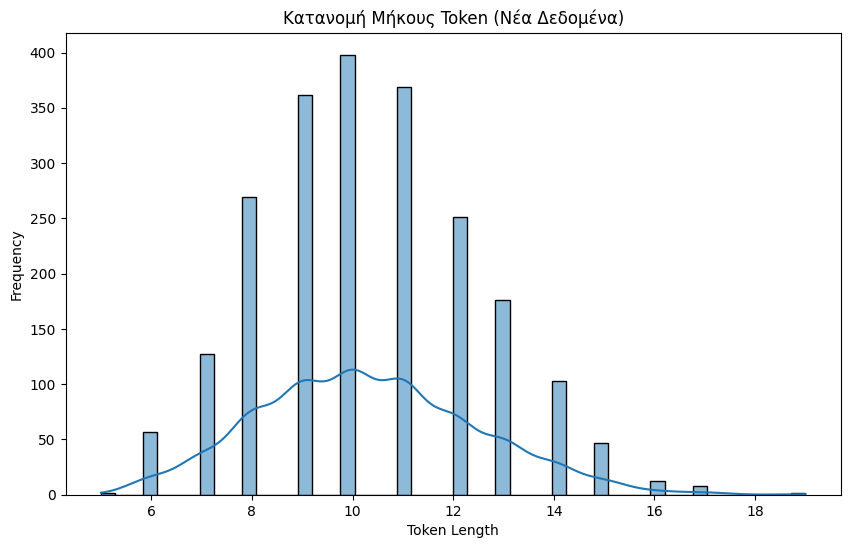

Μέγιστο μήκος token που βρέθηκε: 19
99ο Εκατοστημόριο (Percentile): 15

✓ H μεταβλητή MAX_LENGTH ορίστηκε σε: 15
Αυτή η τιμή θα χρησιμοποιηθεί αυτόματα στην εκπαίδευση.


In [ ]:
# --- 4. Εύρεση Βέλτιστου Max Length (στα νέα δεδομένα) ---
print("--- 4. Εύρεση Βέλτιστου Max Length ---")

# ΣΗΜΑΝΤΙΚΟ: Αυτό το κελί τρέχει ΜΕΤΑ τον καθαρισμό (που έφτιαξε το 'df_full')
# και ΜΕΤΑ τα imports (που έφτιαξαν τον 'tokenizer').

# Define the tokenizer here to ensure it's available
from transformers import BertTokenizer
model_name = "nlpaueb/bert-base-greek-uncased-v1" # Ensure model_name is defined
tokenizer = BertTokenizer.from_pretrained(model_name)


print("Υπολογισμός μήκους token για όλες τις εγγραφές (αυτό μπορεί να πάρει λίγο χρόνο)...")

# Χρησιμοποιούμε το 'df_full' και το 'processed_text' που φτιάξαμε στο προηγούμενο βήμα
token_lengths = [len(tokenizer.encode(text, max_length=512, truncation=True))
                 for text in df_full['processed_text']]

print("Ο υπολογισμός ολοκληρώθηκε.")

# --- Σχεδίαση Κατανομής ---
plt.figure(figsize=(10, 6))
sns.histplot(token_lengths, kde=True, bins=50).set_title('Κατανομή Μήκους Token (Νέα Δεδομένα)')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

# --- Εύρεση 99ου Εκατοστημορίου ---
# Βρίσκουμε το 99% percentile για να καλύψουμε σχεδόν όλα τα κείμενα
max_length_calc = int(np.percentile(token_lengths, 99))

print(f'Μέγιστο μήκος token που βρέθηκε: {max(token_lengths)}')
print(f'99ο Εκατοστημόριο (Percentile): {max_length_calc}')

# Αποθηκεύουμε τη μεταβλητή για να τη χρησιμοποιήσουμε αυτόματα
MAX_LENGTH = max_length_calc

print(f"\n✓ H μεταβλητή MAX_LENGTH ορίστηκε σε: {MAX_LENGTH}")
print("Αυτή η τιμή θα χρησιμοποιηθεί αυτόματα στην εκπαίδευση.")

Using MAX_LENGTH = 15 (from previous cell)
Using device: cuda
Number of Labels (NUM_LABELS): 10
Class weights tensor: tensor([0.9683, 0.9640, 0.9596, 0.9772, 0.9817, 0.9772, 1.7120, 0.9469, 0.9772,
        0.8629], device='cuda:0')
Tokenizing data...
DataLoaders are ready.
Initializing model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Starting final training... ---
Epoch 1/5 - Avg Loss: 2.2389
Epoch 2/5 - Avg Loss: 1.6550
Epoch 3/5 - Avg Loss: 0.7464
Epoch 4/5 - Avg Loss: 0.3436
Epoch 5/5 - Avg Loss: 0.1860

--- Running Validation... ---

--- Validation Results ---
                      precision    recall  f1-score   support

Αποχέτευση / Ύδρευση       1.00      1.00      1.00        55
      Δημόσιοι χώροι       0.88      0.89      0.88        55
      Ζώα / Αδέσποτα       0.98      0.95      0.96        56
          Ηχορύπανση       1.00      0.93      0.96        55
         Καθαριότητα       0.93      0.93      0.93        55
          Κυκλοφορία       0.91      0.96      0.94        55
            Οδοποιία       0.83      0.94      0.88        31
          Πεζοδρόμια       0.98      0.89      0.93        56
            Πρασίνου       0.86      0.89      0.88        55
            Φωτισμός       0.97      0.98      0.98        62

            accuracy                           0.94       535
           mac

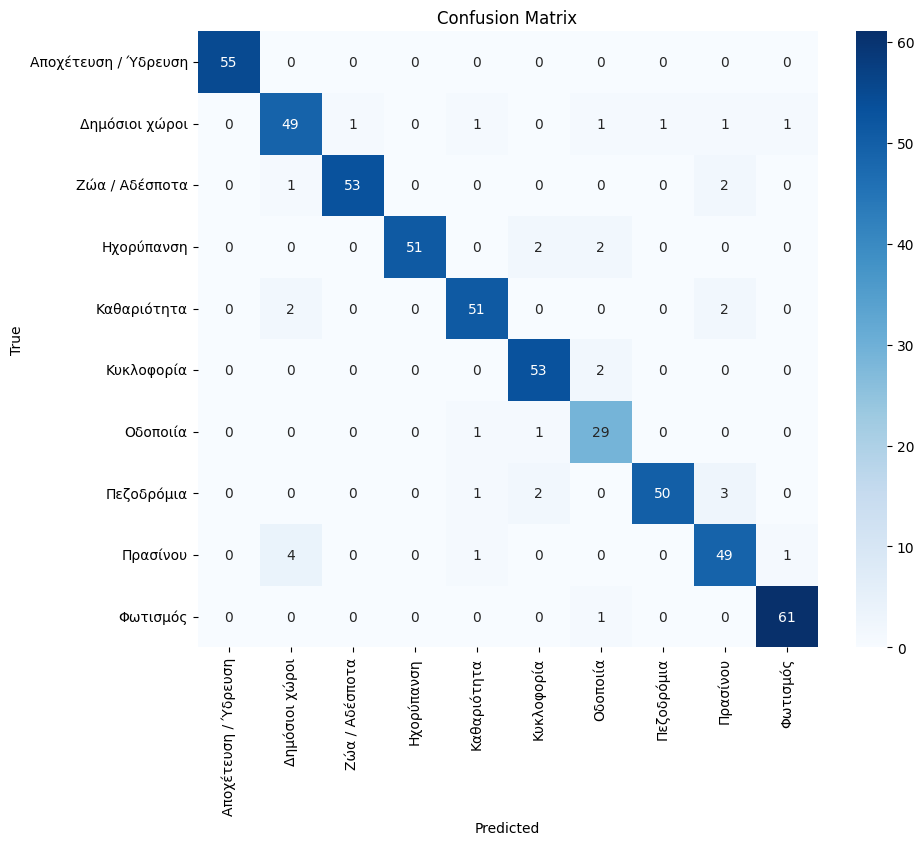

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
import torch.nn as nn
import os
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json

# --- 6. Ορισμός Παραμέτρων ---
model_name = "nlpaueb/bert-base-greek-uncased-v1"
batch_size = 32  # Μπορεί να χρειαστεί να το μειώσετε (π.χ. 16 ή 64)
num_epochs = 5
# Χρησιμοποιούμε τη μεταβλητή MAX_LENGTH που βρέθηκε στο προηγούμενο κελί
# Αν το προηγούμενο κελί δεν έχει ορίσει το MAX_LENGTH, ορίστε το εδώ (π.χ. max_length = 19)
try:
    max_length = MAX_LENGTH
    print(f"Using MAX_LENGTH = {max_length} (from previous cell)")
except NameError:
    print("Warning: MAX_LENGTH not found. Setting to 19. Run cell [4] to find optimal length.")
    max_length = 19

learning_rate = 2e-5
accumulation_steps = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_MODEL_DIR = "final_issue_category_model" # Νέο όνομα φακέλου

# --- 6.1 Υπολογισμός Βαρών & NUM_LABELS (Από προηγούμενα κελιά) ---
# Αυτό προϋποθέτει ότι τα κελιά φόρτωσης & split (που ορίζουν y_train, y_val, id_to_label, label_to_id) έχουν εκτελεστεί.

# Υπολογισμός NUM_LABELS
NUM_LABELS = len(id_to_label)

# Υπολογισμός Class Weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(f"Using device: {device}")
print(f"Number of Labels (NUM_LABELS): {NUM_LABELS}")
print(f"Class weights tensor: {class_weights_tensor}")

# --- 7. Tokenization & DataLoaders ---
tokenizer = BertTokenizer.from_pretrained(model_name)

print("Tokenizing data...")
train_encodings = tokenizer(list(X_train), truncation=True, padding='max_length', max_length=max_length)
val_encodings = tokenizer(list(X_val), truncation=True, padding='max_length', max_length=max_length)

train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(y_train.values, dtype=torch.long) # <-- ΔΙΟΡΘΩΣΗ 1: Εξασφάλιση Long
)
val_dataset = TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(y_val.values, dtype=torch.long) # <-- ΔΙΟΡΘΩΣΗ 1: Εξασφάλιση Long
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print("DataLoaders are ready.")

# --- 8. Αρχικοποίηση Μοντέλου & Optimizer ---
print("Initializing model...")
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS)
model.to(device)
model = model.float() # <-- ΔΙΟΡΘΩΣΗ 2: Εξασφάλιση ότι το μοντέλο είναι float32
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)

# --- 9. Training Loop ---
print("\n--- Starting final training... ---")
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    batch_count = 0
    optimizer.zero_grad()

    for batch_idx, batch in enumerate(train_loader):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits # Δεν χρειάζεται πλέον .float() εδώ, αφού το μοντέλο είναι ήδη .float()

        loss = loss_fct(logits.view(-1, NUM_LABELS), labels.view(-1))
        loss = loss / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss += loss.item() * accumulation_steps
        batch_count += 1

    avg_loss = epoch_loss / batch_count
    print(f"Epoch {epoch + 1}/{num_epochs} - Avg Loss: {avg_loss:.4f}")

# --- 10. Validation ---
print("\n--- Running Validation... ---")
model.eval()
val_preds = []
val_labels = []
with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# --- 11. Εμφάνιση Αποτελεσμάτων ---
print("\n--- Validation Results ---")
# Μετατροπή των αριθμητικών labels πάλι σε string labels για το report
target_names = [id_to_label[i] for i in range(NUM_LABELS)]
print(classification_report(val_labels, val_preds, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png") # Αποθήκευση της εικόνας
print("Confusion matrix saved as confusion_matrix.png")

# --- 12. Αποθήκευση Τελικού Μοντέλου ---
print("\nTraining complete.")
print(f"Saving final model and tokenizer to directory: '{OUTPUT_MODEL_DIR}'...")

if not os.path.exists(OUTPUT_MODEL_DIR):
    os.makedirs(OUTPUT_MODEL_DIR)

model.save_pretrained(OUTPUT_MODEL_DIR)
tokenizer.save_pretrained(OUTPUT_MODEL_DIR)

# Αποθήκευση και του label mapping
with open(os.path.join(OUTPUT_MODEL_DIR, 'label_map.json'), 'w', encoding='utf-8') as f:
    json.dump({'label_to_id': label_to_id, 'id_to_label': id_to_label}, f, ensure_ascii=False, indent=4)

print("\n✓✓✓ FINAL MODEL SAVED! ✓✓✓")

In [ ]:
import os
import shutil
from google.colab import drive

# --- 1. Καθαρισμός παλιού mount point (για να λυθεί το σφάλμα) ---
print("--- 1. Καθαρισμός παλιού mount point... ---")
# Αυτή η εντολή διαγράφει τον "ορφανό" τοπικό φάκελο του Colab
!rm -rf /content/drive
print("Καθαρισμός ΟΚ.")

# Ορισμός φακέλων
source_folder = "/content/final_issue_category_model"
destination_folder = "/content/drive/MyDrive/final_issue_category_model"

print("\n--- 2. Σύνδεση με το Google Drive ---")
try:
    # Τώρα η σύνδεση θα πετύχει
    drive.mount('/content/drive')
    print("   ✓ Το Google Drive συνδέθηκε επιτυχώς.")

    # --- 3. Έλεγχος και Αντιγραφή (ΜΟΝΟ ΑΦΟΥ ΣΥΝΔΕΘΗΚΕ) ---
    print("\n--- 3. Έλεγχος και Αντιγραφή ---")

    # Έλεγχος αν το μοντέλο υπάρχει (στο Colab)
    if not os.path.exists(source_folder):
        print(f"❌ ΣΦΑΛΜΑ ΠΗΓΗΣ: Δεν βρέθηκε ο φάκελος '{source_folder}' στο Colab.")
        print("Βεβαιωθείτε ότι το κελί εκπαίδευσης έχει τρέξει πρώτα.")
    else:
        # Τώρα αυτός ο έλεγχος κοιτάει το *πραγματικό* Drive
        if os.path.exists(destination_folder):
            print(f"⚠ ΠΡΟΣΟΧΗ: Ο φάκελος '{destination_folder}' υπάρχει ήδη στο *πραγματικό* σου Drive.")
            print("Η αντιγραφή παραλείφθηκε.")
            print("(Αν θες να τον αντικαταστήσεις, διέγραψέ τον χειροκίνητα από το Drive σου και ξανατρέξε το κελί)")
        else:
            # Η αντιγραφή θα γίνει τώρα
            print("Ο φάκελος δεν υπάρχει στο Drive. Ξεκινά η αντιγραφή...")
            shutil.copytree(source_folder, destination_folder)
            print(f"\n✓✓✓ ΕΠΙΤΥΧΙΑ! ✓✓✓")
            print("Το μοντέλο αποθηκεύτηκε στο Google Drive σου!")

except Exception as e:
    print(f"\n❌ ΣΦΑΛΜΑ κατά τη σύνδεση ή την αντιγραφή: {e}")

--- 1. Καθαρισμός παλιού mount point... ---
Καθαρισμός ΟΚ.

--- 2. Σύνδεση με το Google Drive ---
Mounted at /content/drive
   ✓ Το Google Drive συνδέθηκε επιτυχώς.

--- 3. Έλεγχος και Αντιγραφή ---
Ο φάκελος δεν υπάρχει στο Drive. Ξεκινά η αντιγραφή...

✓✓✓ ΕΠΙΤΥΧΙΑ! ✓✓✓
Το μοντέλο αποθηκεύτηκε στο Google Drive σου!
